<a href="https://colab.research.google.com/github/Relo02/Visual-Inertia-Odometry/blob/main/Visual_Odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# depth estimation dataset
!unzip "/content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/depth/trajectory_0000/frames.zip" -d "/content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/depth/trajectory_0000/"

In [ ]:
# color_down images
!unzip "/content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/color_down/trajectory_0000/frames.zip" -d "/content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/color_down/trajectory_0000/"

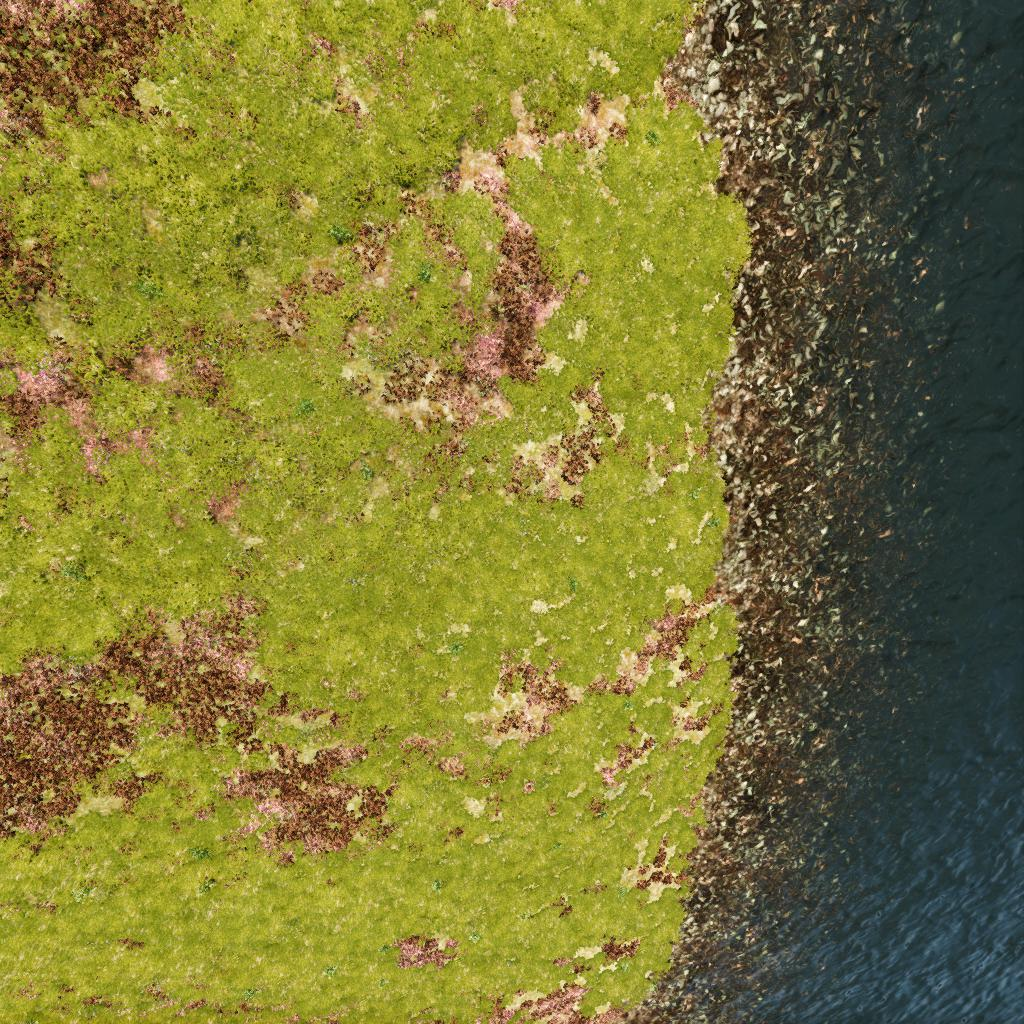

In [18]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Load dataset from local folder
data_sunny_depth_dir = '/content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/depth/trajectory_0000'
data_sunny_color_down_dir = '/content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/color_down/trajectory_0000'
data_foggy_dir = '/content/drive/MyDrive/Mid-Air-dataset/Kite_training/foggy/trajectory_0000' # Assuming similar structure for foggy
color_down_imgs = []

# Filter for image files (assuming .png or .jpg extensions)
sunny_depth_files = sorted([f for f in os.listdir(data_sunny_depth_dir)
                            if f.endswith('.png') or f.endswith('.JPEG')])
sunny_color_down_files = sorted([f for f in os.listdir(data_sunny_color_down_dir)
                            if f.endswith('.png') or f.endswith('.JPEG')])
# foggy_files = sorted([f for f in os.listdir(data_foggy_dir) if f.endswith('.png') or f.endswith('.JPEG')]) # Uncomment if foggy data is needed

# Example: Display the first depth image
"""
if sunny_depth_files:
    first_sunny_depth_img_path = os.path.join(data_sunny_depth_dir, sunny_depth_files[0])
    first_sunny_depth_img = cv2.imread(first_sunny_depth_img_path)

    if first_sunny_depth_img is not None:
        cv2_imshow(first_sunny_depth_img)
    else:
        print(f"Error loading image: {first_sunny_depth_img_path}")
else:
    print(f"No image files found in {data_sunny_depth_dir}")
"""

# Example: Display the first color_down image
if sunny_color_down_files:
    first_sunny_color_down_img_path = os.path.join(data_sunny_color_down_dir, sunny_color_down_files[0])
    first_sunny_color_down_img = cv2.imread(first_sunny_color_down_img_path)

    if first_sunny_color_down_img is not None:
        cv2_imshow(first_sunny_color_down_img)
    else:
        print(f"Error loading image: {first_sunny_color_down_img_path}")
else:
    print(f"No image files found in {data_sunny_color_down_dir}")

In [19]:
# Convert the raw color_down images into rgb scale
rgb_images = []

for image_path in sunny_color_down_files:
    full_image_path = os.path.join(data_sunny_color_down_dir, image_path)
    img = cv2.imread(full_image_path)
    if img is not None:
        # OpenCV loads images in BGR, convert to RGB
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        rgb_images.append(rgb_img)

print(f"Loaded and converted {len(rgb_images)} images to RGB.")

Loaded and converted 2205 images to RGB.


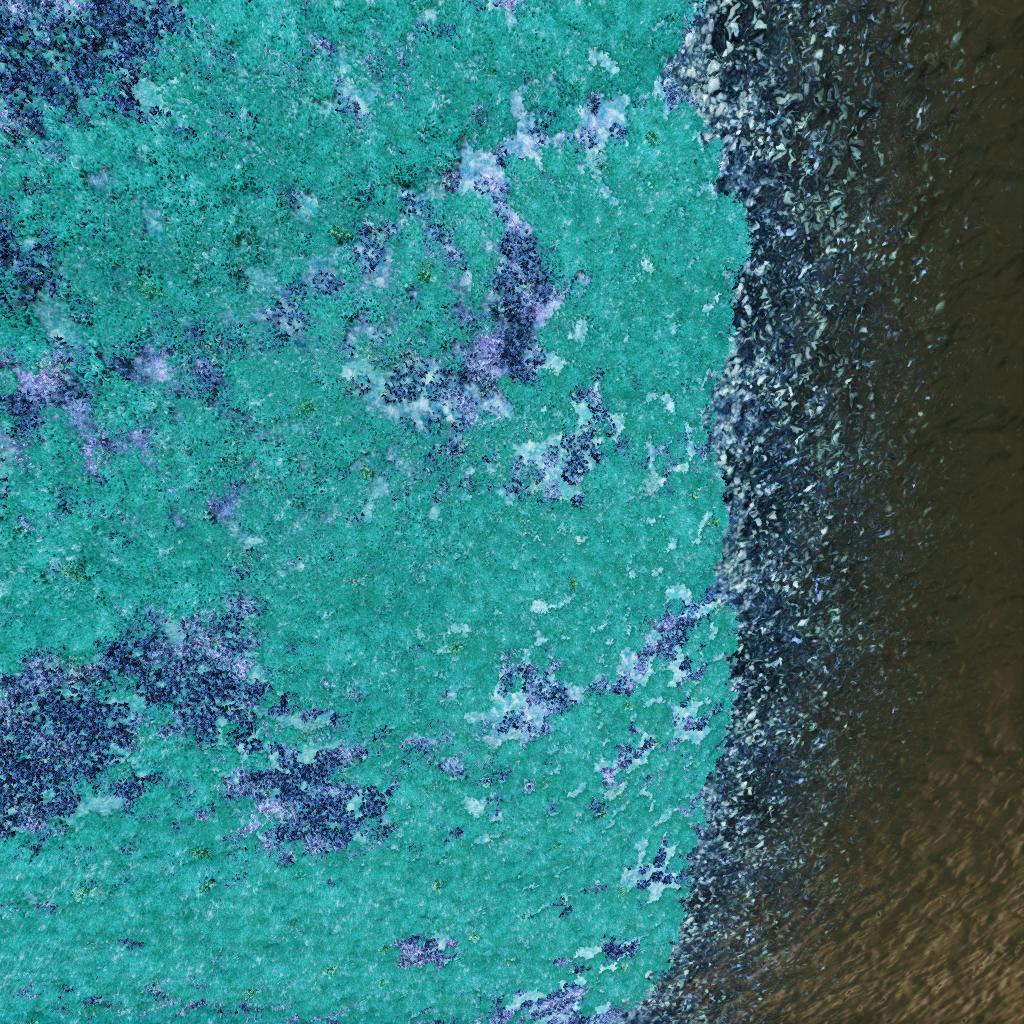

In [20]:
cv2_imshow(rgb_images[0])

In [21]:
# Load the groundtruth pose from dataset
!unzip "/content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/sensor_records.zip" -d "/content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny"

Archive:  /content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/sensor_records.zip
  inflating: /content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/sensor_records.hdf5  


In [40]:
import h5py

sensor_path_readings = "/content/drive/MyDrive/Mid-Air-dataset/Kite_training/sunny/sensor_records.hdf5"

with h5py.File(sensor_path_readings, 'r') as f:
    keys_list = list(f.keys())          # Get all top-level keys as a list
    specific_key = keys_list[0]         # Access the first key (trajectory_0000)
    print(f"Keys within group '{specific_key}': {list(f[specific_key].keys())}") # Print keys within the trajectory_0000 group
    groundtruth_group = f[specific_key]['groundtruth']
    print(f"Type of 'groundtruth' object: {type(groundtruth_group)}")
    print(f"Keys within group 'groundtruth': {list(groundtruth_group.keys())}") # Print keys within the groundtruth group
    groundtruth_position_data = f[specific_key]['groundtruth']['position'][()]  # Access the 'position' dataset within the groundtruth group

print("\nGroundtruth Position data:")
print(groundtruth_position_data[10]) # Print the first element of the position dataset

Keys within group 'trajectory_0000': ['camera_data', 'gps', 'groundtruth', 'imu']
Type of 'groundtruth' object: <class 'h5py._hl.group.Group'>
Keys within group 'groundtruth': ['acceleration', 'angular_velocity', 'attitude', 'position', 'velocity']

Groundtruth Position data:
[1.56413102 0.28029545 0.20349882]


In [41]:
# Creating consecutive tuples frames
pairs = [(rgb_images[i], rgb_images[i+1]) for i in range(len(rgb_images)-1)]

# Print the first pair for testing
print(pairs[0])

(array([[[163, 115, 103],
        [187, 139, 125],
        [101,  53,  39],
        ...,
        [ 36,  52,  51],
        [ 35,  51,  50],
        [ 35,  51,  50]],

       [[142,  94,  80],
        [192, 144, 130],
        [104,  57,  41],
        ...,
        [ 35,  51,  50],
        [ 35,  51,  50],
        [ 34,  50,  49]],

       [[165, 118, 102],
        [173, 126, 108],
        [155, 108,  90],
        ...,
        [ 34,  50,  49],
        [ 34,  50,  49],
        [ 34,  50,  49]],

       ...,

       [[150, 145,  28],
        [136, 131,  14],
        [148, 143,  26],
        ...,
        [ 46,  70,  80],
        [ 42,  67,  74],
        [ 37,  62,  69]],

       [[161, 158,  43],
        [142, 139,  24],
        [142, 139,  24],
        ...,
        [ 46,  70,  80],
        [ 41,  66,  73],
        [ 34,  59,  64]],

       [[163, 160,  45],
        [148, 145,  30],
        [134, 131,  16],
        ...,
        [ 43,  68,  75],
        [ 40,  65,  72],
        [ 37,  62,  67]